**Get data from Kaggle**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)
from google.colab import files
files.upload()

Mounted at /content/drive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annalisabarbara","key":"f3e17385dc26a70415d8fbf3d93ef180"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
!kaggle datasets download -d parthplc/facebook-hateful-meme-dataset

100% 3.35G/3.35G [02:00<00:00, 32.4MB/s]
100% 3.35G/3.35G [02:00<00:00, 29.9MB/s]


In [ ]:
#!kaggle datasets download -d parthplc/facebook-hateful-meme-dataset

!unzip /content/facebook-hateful-meme-dataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: data/img/49758.png      
  inflating: data/img/49762.png      
  inflating: data/img/49785.png      
  inflating: data/img/49786.png      
  inflating: data/img/49802.png      
  inflating: data/img/49805.png      
  inflating: data/img/49806.png      
  inflating: data/img/49807.png      
  inflating: data/img/49810.png      
  inflating: data/img/49826.png      
  inflating: data/img/49831.png      
  inflating: data/img/49832.png      
  inflating: data/img/49836.png      
  inflating: data/img/49850.png      
  inflating: data/img/49856.png      
  inflating: data/img/49861.png      
  inflating: data/img/49863.png      
  inflating: data/img/49867.png      
  inflating: data/img/49870.png      
  inflating: data/img/50124.png      
  inflating: data/img/50126.png      
  inflating: data/img/50129.png      
  inflating: data/img/50137.png      
  inflating: data/img/50142.png      
  inflating: data/img/50146.png      


In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.1 MB/s eta 0:00:00


In [ ]:
'''
IMPORTING NECESSARY MODULES
'''

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter


sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/BERT')
sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/multimodal-memes')
sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/Utils')
sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/Data')
sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/Resnet')
sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/multimodal-memes/Data/img')

from dataloader import myfusiondataset
#from Load_model import load
from plot_curves import plot_loss, plot_acc
from multimodal_trainer import train, test_classify

'''
For ResNet/ ResNeXt
'''
from resnet_model import ResNet,Bottleneck, resnext101_32x8d


'''
For BERT
'''
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

**Device**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


**Dataloading Scheme**

In [ ]:
%cd /content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/JSON Data

/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/JSON Data


In [ ]:
#%cd /content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/data/img

In [ ]:
trainlist = 'train.jsonl'
validlist = 'dev_seen.jsonl'

In [ ]:
'''
Train Dataloader
''' 
train_dataset = myfusiondataset(trainlist, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 32, num_workers=8,pin_memory=True)


'''
Validation Dataloader
''' 
validation_dataset = myfusiondataset(validlist, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 16, num_workers=8,pin_memory=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_ms

**Model Definition**

In [ ]:
'''
Model1 ResNeXt101_32x8d
'''
Image_model = resnext101_32x8d()

Image_model.fc = nn.Sequential(
    nn.Linear(Image_model.fc.in_features, 2)
    )

Image_model = nn.DataParallel(Image_model).to(device)

#Image_model.to(device)

In [ ]:
'''
Model 2 BERT

Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
''' 

Text_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = True
)

Text_model = nn.DataParallel(Text_model).to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
'''
Fusion
'''
class FusionNet(nn.Module):
    
    def __init__(self, num_classes, drop_prob = 0.1):
        super(FusionNet, self).__init__()
        
        self.pooler = nn.Linear(in_features=768, out_features=768)
        
        self.concat = nn.Linear(in_features=768+2048, out_features= 512)
        
        self.bn = nn.BatchNorm1d(512)
        self.bn1 = nn.BatchNorm1d(768)
        self.bn2 = nn.BatchNorm1d(2048)
    
        self.dropout = nn.Dropout(drop_prob)
        
        self.classify = nn.Linear(in_features = 512, out_features = num_classes)
        
        
    def forward(self, text_features, image_features):
        text_features = torch.tanh(self.pooler(text_features))
        text_features = self.dropout(text_features)

        text_features = self.bn1(text_features)
        image_features = self.bn2(image_features)
      
        fused =  torch.cat((text_features, image_features), dim=1)
      
        x = self.concat(fused)
  
        x = F.tanh(self.bn(x))          
  
        x = F.tanh(self.classify(x)) 
  

        return x



In [ ]:
Fusion_model = FusionNet(num_classes =2 , drop_prob = 0.1)
Fusion_model = nn.DataParallel(Fusion_model).to(device)

In [ ]:
%cd /content/data

/content/data


**Hyperparameters**

In [ ]:
'''
Loss Function
'''
criterion = nn.CrossEntropyLoss()

'''
Optimizer
'''
# optimizer = torch.optim.Adam(Fusion_model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.01)
# loss = CrossEntropy
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 4, gamma = 0.1)
# optimizer = torch.optim.Adam(Fusion_model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.01)
# Epoch:  15
# training loss =  0.5030899883661055
# Validation Loss: 0.7874	Validation Accuracy: 0.5700

# optimizer = torch.optim.Adam(Fusion_model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.05)
# loss = CrossEntropy
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma = 0.1)
# Epoch:  10
# training loss =  0.5289563782008967
# Validation Loss: 0.7647	Validation Accuracy: 0.5720

optimizer = torch.optim.Adam(Fusion_model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.01)


'''
Number of training epochs.
'''
num_Epochs = 10


lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma = 0.1)

In [ ]:
model_name = 'Concatenation + BERT'
model_path = './saved_model_checkpoints/'+ model_name
#model_path = 'content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes'+model_name

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
 import itertools

 def grid_search(model, criterion, hyperparameters):
     best_accuracy = 0
     best_hyperparameters = {}
     hyperparameter_combinations = list(itertools.product(*hyperparameters.values()))

     for combination in hyperparameter_combinations:
        hyperparameter_dict = dict(zip(hyperparameters.keys(), combination))
        print("Testing with hyperparameters: ", hyperparameter_dict)

        optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameter_dict['learning_rate'], 
                                     weight_decay=hyperparameter_dict['weight_decay'], 
                                     momentum=hyperparameter_dict['momentum'])

        num_Epochs = hyperparameter_dict['num_Epochs']
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma= hyperparameter_dict['gamma'])

        writer = SummaryWriter(model_name)


        train_loss, v_loss, v_acc = train(Image_model, Text_model, Fusion_model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, model_path, writer, device, epochs = num_Epochs)

        plot_loss(num_Epochs, train_loss, v_loss, 'XLNet + Resnet')

        plot_acc(num_Epochs, v_acc)
        
        
        print(f"{v_acc=} {v_loss=} {hyperparameter_dict['learning_rate'] = } {hyperparameter_dict['weight_decay']=} {hyperparameter_dict['momentum'] = } {hyperparameter_dict['num_Epochs']=}")
         #if v_acc > best_accuracy:
           #best_accuracy = v_acc
           #best_hyperparameters = hyperparameter_dict



        writer.flush()
        writer.close()

        plot_loss(num_Epochs, train_loss, v_loss, 'XLNet + Resnet')

        plot_acc(num_Epochs, v_acc)

     print("\nBest Hyperparameters Found:")
     print(best_hyperparameters)
     print(f"\nBest Validation Accuracy: {best_accuracy:.4f}")
     return best_hyperparameters

Testing with hyperparameters:  {'learning_rate': 0.0001, 'weight_decay': 0.0001, 'gamma': 0.1, 'momentum': 0.7, 'num_Epochs': 8}
Epoch:  1
training loss =  0.7069426232710817
Validation Loss: 0.7122	Validation Accuracy: 0.5220
Epoch:  2
training loss =  0.6667405082319016
Validation Loss: 0.7056	Validation Accuracy: 0.5360
Epoch:  3
training loss =  0.6580704786723718
Validation Loss: 0.7037	Validation Accuracy: 0.5260
Epoch:  4
training loss =  0.6548225852779876
Validation Loss: 0.7066	Validation Accuracy: 0.5320
Epoch:  5
training loss =  0.6535181022228155
Validation Loss: 0.7058	Validation Accuracy: 0.5360
Epoch:  6
training loss =  0.6557474277521435
Validation Loss: 0.7059	Validation Accuracy: 0.5400
Epoch:  7
training loss =  0.6528401728859521
Validation Loss: 0.7067	Validation Accuracy: 0.5280
Epoch:  8
training loss =  0.6568531687546494
Validation Loss: 0.7067	Validation Accuracy: 0.5300
v_acc=[0.522, 0.536, 0.526, 0.532, 0.536, 0.54, 0.528, 0.53] v_loss=[0.7122016673088074

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:  1
training loss =  0.6235940106829306
Validation Loss: 0.7520	Validation Accuracy: 0.5120
Epoch:  2
training loss =  0.5824173482737147
Validation Loss: 0.7532	Validation Accuracy: 0.5520
Epoch:  3
training loss =  0.5587249412796551
Validation Loss: 0.7812	Validation Accuracy: 0.5520
Epoch:  4
training loss =  0.5506671935992133
Validation Loss: 0.7760	Validation Accuracy: 0.5540
Epoch:  5
training loss =  0.5491162141911069
Validation Loss: 0.7778	Validation Accuracy: 0.5540
Epoch:  6
training loss =  0.5492243082227564
Validation Loss: 0.7829	Validation Accuracy: 0.5540
Epoch:  7
training loss =  0.5504082919735658
Validation Loss: 0.7707	Validation Accuracy: 0.5580
Epoch:  8
training loss =  0.5474698881905778
Validation Loss: 0.7761	Validation Accuracy: 0.5640
v_acc=[0.512, 0.552, 0.552, 0.554, 0.554, 0.554, 0.558, 0.564] v_loss=[0.7519826261997223, 0.7532331318855285, 0.7811767208576202, 0.776024341583252, 0.7777845735549926, 0.7828965590000153, 0.7706905424594879, 0.7760

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:  1
training loss =  0.5498157021470536
Validation Loss: 0.7845	Validation Accuracy: 0.5580
Epoch:  2
training loss =  0.5484264319328437
Validation Loss: 0.7828	Validation Accuracy: 0.5600
Epoch:  3
training loss =  0.549901814725166
Validation Loss: 0.7919	Validation Accuracy: 0.5500
Epoch:  4
training loss =  0.5470381800393412
Validation Loss: 0.7920	Validation Accuracy: 0.5540
Epoch:  5
training loss =  0.5442097743875102
Validation Loss: 0.7968	Validation Accuracy: 0.5480
Epoch:  6
training loss =  0.5444029216703615
Validation Loss: 0.7864	Validation Accuracy: 0.5620
Epoch:  7
training loss =  0.5478031952354244
Validation Loss: 0.7818	Validation Accuracy: 0.5620
Epoch:  8
training loss =  0.5471950720127364
Validation Loss: 0.7849	Validation Accuracy: 0.5640
v_acc=[0.558, 0.56, 0.55, 0.554, 0.548, 0.562, 0.562, 0.564] v_loss=[0.7845172057151795, 0.7828283591270446, 0.7918567659854889, 0.7920004017353058, 0.7967672717571258, 0.7863671164512634, 0.7817727444171906, 0.784860

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:  1
training loss =  0.5544991210887307
Validation Loss: 0.8385	Validation Accuracy: 0.5520
Epoch:  2
training loss =  0.548668415138596
Validation Loss: 0.8327	Validation Accuracy: 0.5400
Epoch:  3
training loss =  0.5389532551057357
Validation Loss: 0.7777	Validation Accuracy: 0.5560
Epoch:  4
training loss =  0.534258757991002
Validation Loss: 0.8125	Validation Accuracy: 0.5420
Epoch:  5
training loss =  0.5313779436107865
Validation Loss: 0.7927	Validation Accuracy: 0.5460
Epoch:  6
training loss =  0.527480583329846
Validation Loss: 0.8122	Validation Accuracy: 0.5460
Epoch:  7
training loss =  0.5233551304143175
Validation Loss: 0.8203	Validation Accuracy: 0.5500
Epoch:  8
training loss =  0.5231647151977497
Validation Loss: 0.7959	Validation Accuracy: 0.5560
v_acc=[0.552, 0.54, 0.556, 0.542, 0.546, 0.546, 0.55, 0.556] v_loss=[0.8384570598602294, 0.8327332260608673, 0.7777480235099793, 0.8125351338386536, 0.7926842093467712, 0.8121511306762695, 0.820334213256836, 0.795888291

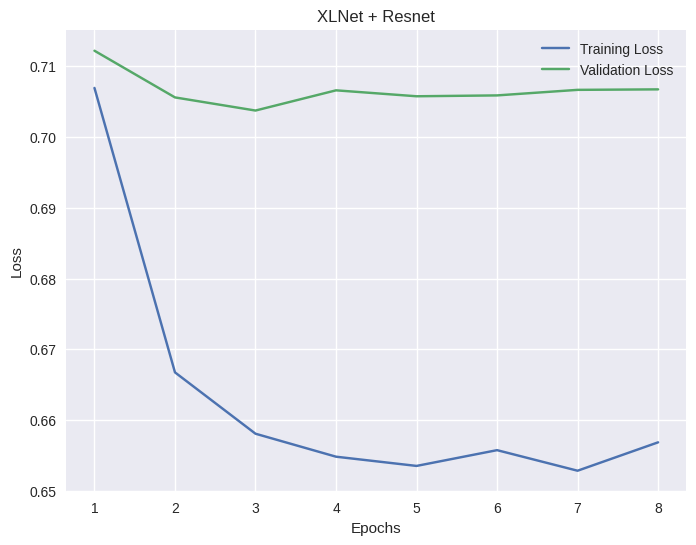

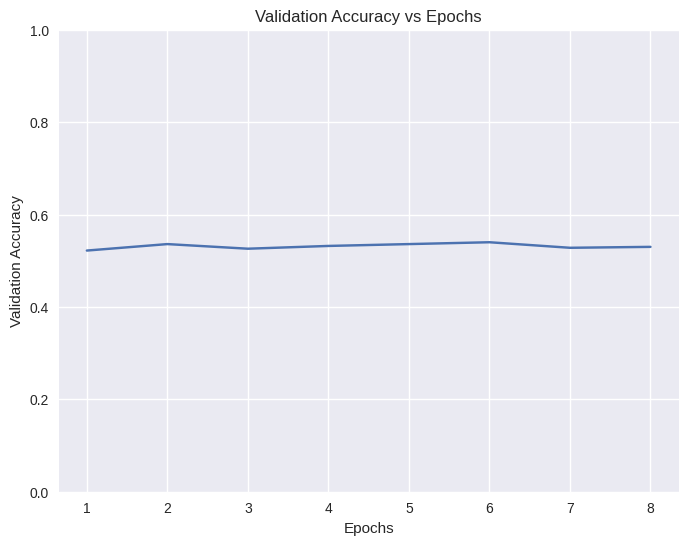

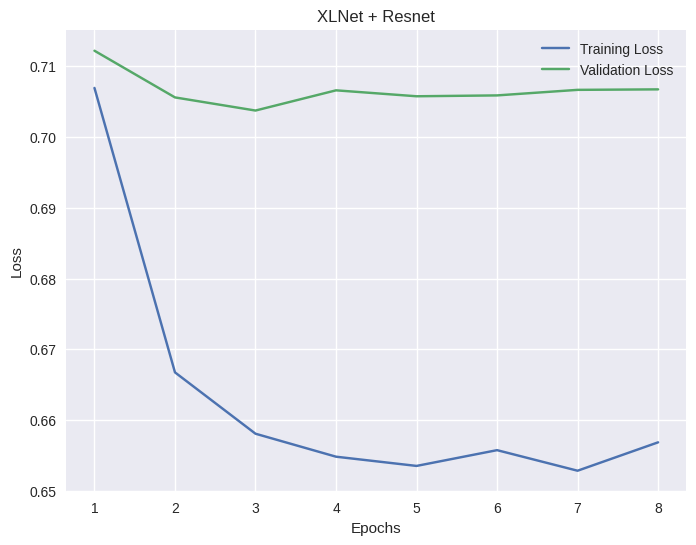

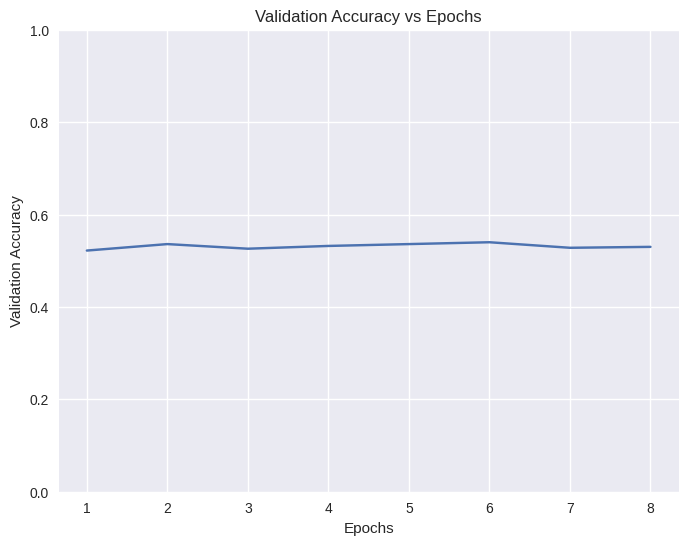

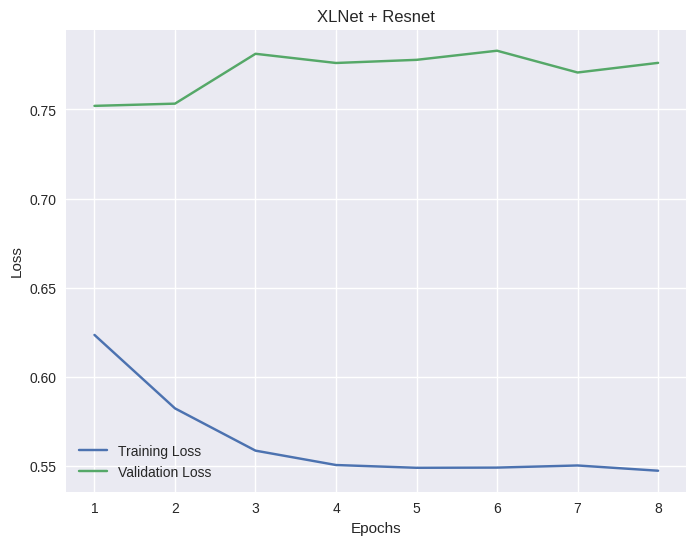

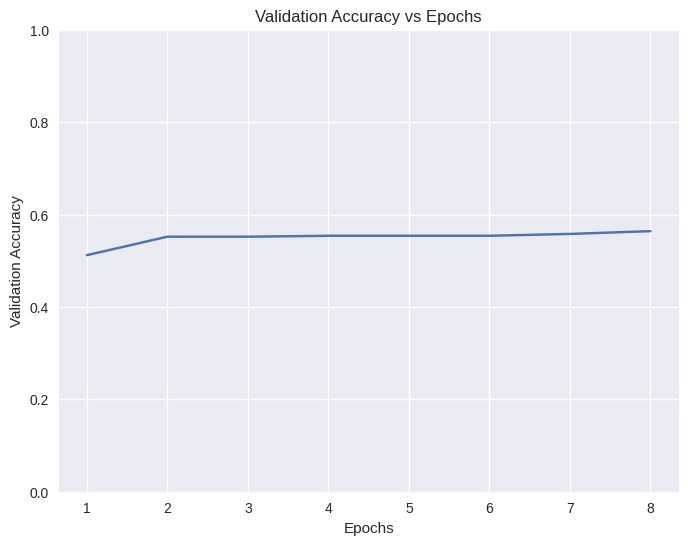

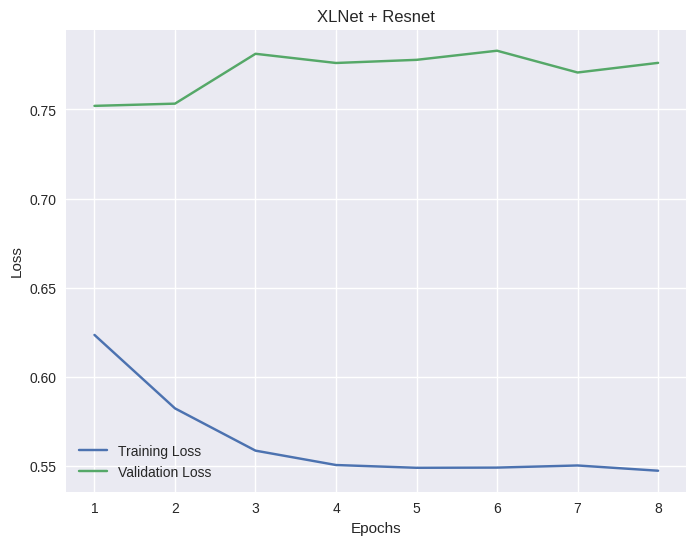

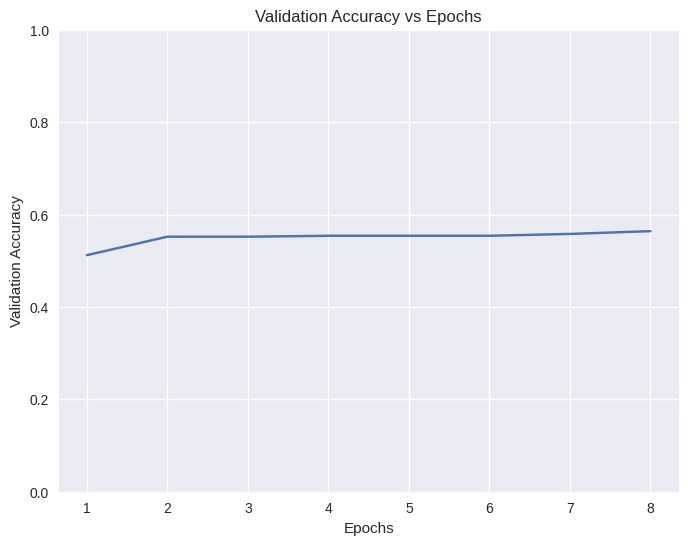

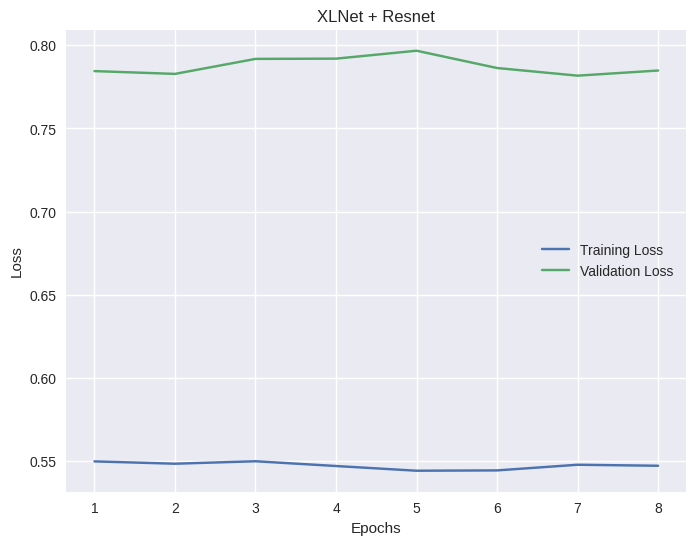

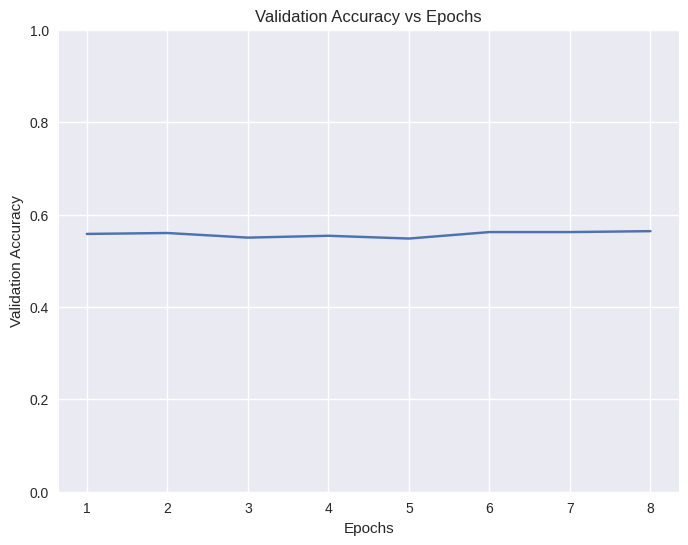

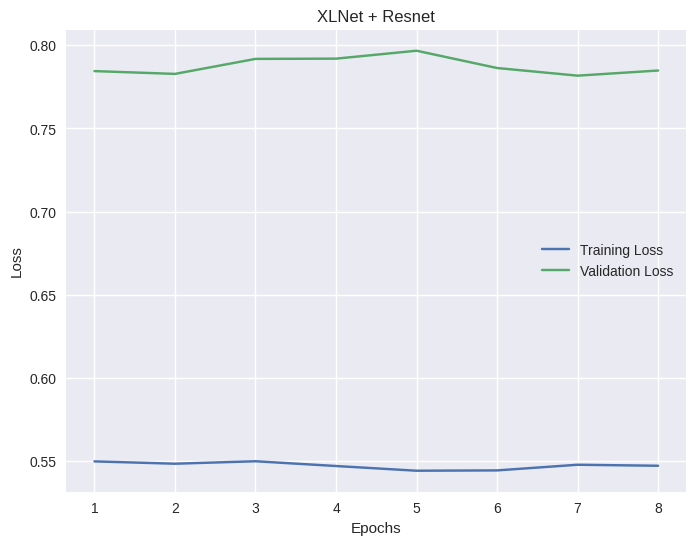

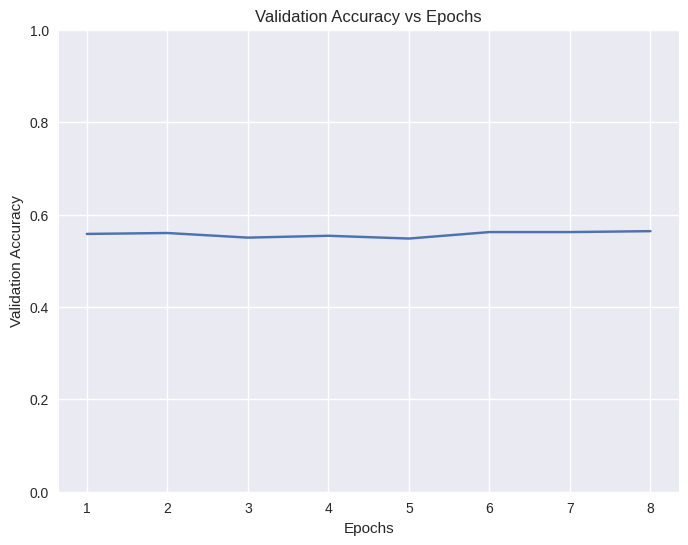

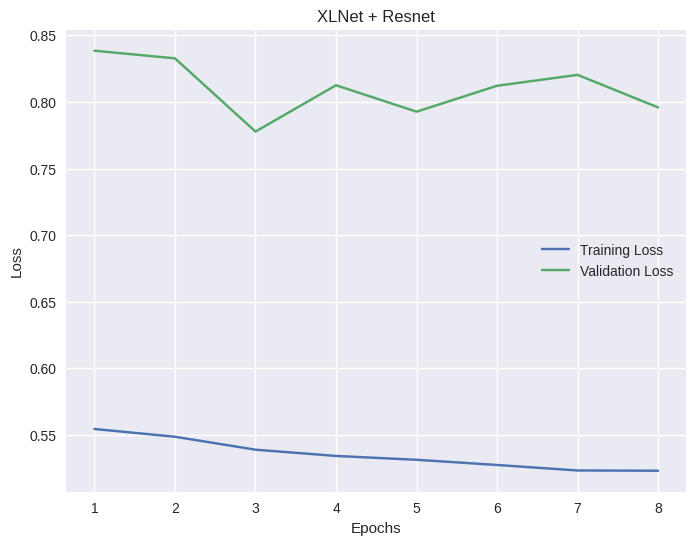

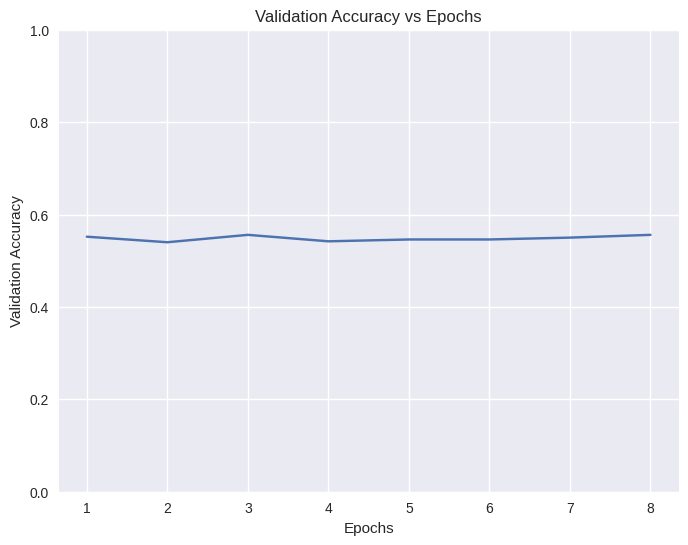

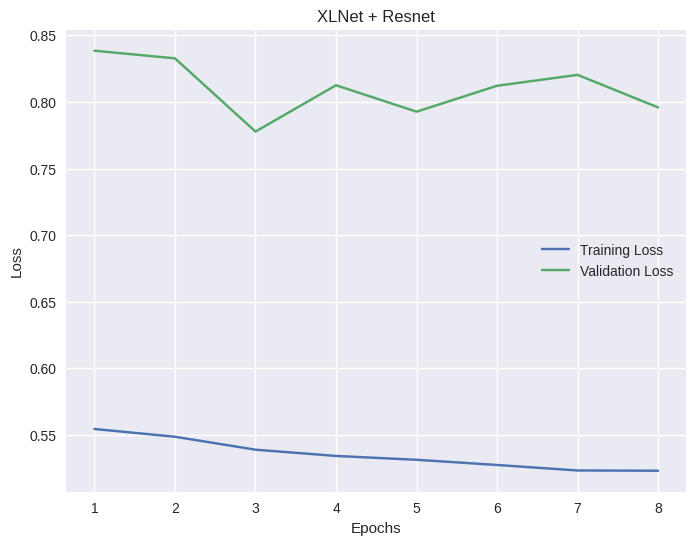

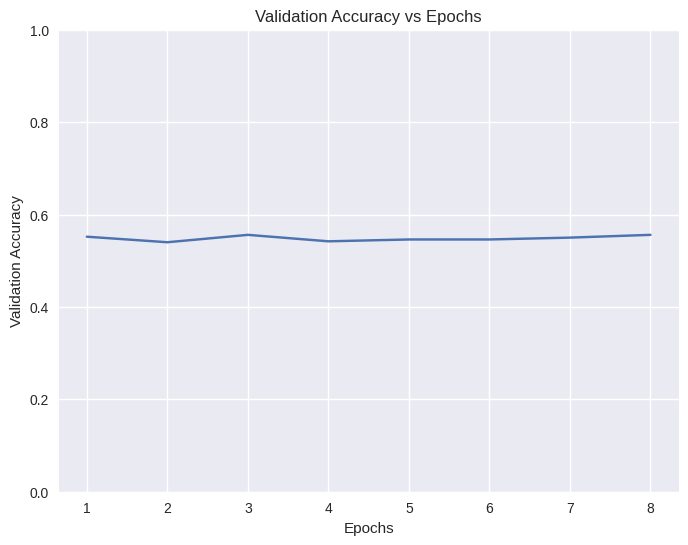

In [ ]:
 hyperparameters = {'learning_rate': [1e-4],
                    'weight_decay': [1e-4],
                    'gamma':[0.1,0.5] ,
                    'momentum': [0.7, 0.99],
                    'num_Epochs': [8]}
 best_hyperparameters = grid_search(Fusion_model, criterion, hyperparameters)

In [ ]:
writer = SummaryWriter(model_name)

train_loss, v_loss, v_acc = train(Image_model, Text_model, Fusion_model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, model_path, writer, device, epochs = num_Epochs)

writer.flush()
writer.close()

Epoch:  1
training loss =  0.6223083094770747
Validation Loss: 0.7610	Validation Accuracy: 0.5060


In [ ]:
#%cd /content/drive/MyDrive/FinalProject/hateful-speech-memes 2

**Evaluate on Validation set**

In [ ]:
plot_loss(num_Epochs, train_loss, v_loss, 'BERT + Resnet')

In [ ]:
plot_acc(num_Epochs, v_acc)